In [30]:
from scipy import misc
import glob
from skimage import io
from skimage.transform import resize
import math
import matplotlib.pyplot as plt
import numpy as np
import pprint as pp
import imutils
import cv2
from skimage.measure import find_contours

%matplotlib inline

In [57]:
images = []

for image_path in glob.glob("dane/set1/*.png"):
    image = io.imread(image_path, as_gray=True)
    images.append(image)

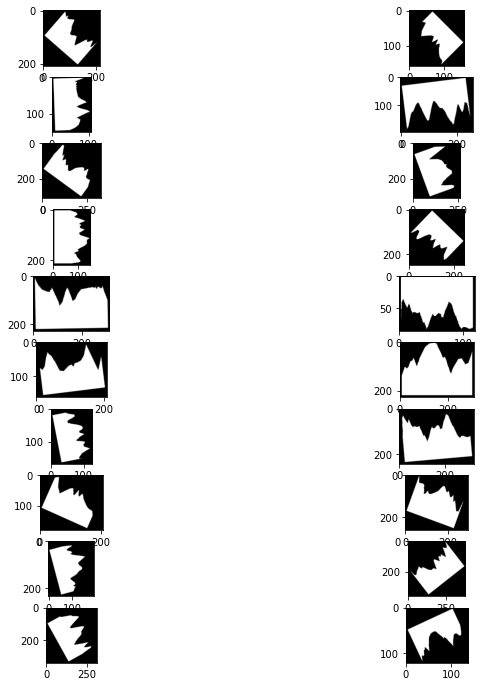

In [58]:
fig, axs = plt.subplots(int(len(images)/2),2, figsize=(12,12))

for index, image in enumerate(images):
    axs[math.floor(index / 2),index % 2].imshow(image, cmap='gray', vmin=0, vmax=255) 


In [59]:
numpyImages = []
for image in images:
    numpyImages.append(np.array(image))

In [60]:
contours = []



for image in numpyImages:    
    contours.append(find_contours(image,0.5))

In [61]:
contursMaps = []
for image in numpyImages:
    contursMaps.append(np.zeros(image.shape, dtype="uint8"))

In [62]:
contours_floors = []

for cont in contours:
    contours_floors.append([(r,c) for r,c in np.floor(cont[0])])

In [63]:
pixelContours = []

neighborhood = [(-1,-1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

for image in numpyImages:
    pixC = []
    for row, line in enumerate(image):
        for column, pixel in enumerate(line):
            if(pixel == 0):
                continue
            for x,y in neighborhood:
                try:
                    if image[row + x, column + y] == 0:
                        pixC.append((row, column))
                        break
                except:
                    print("err")
    pixelContours.append(pixC)

In [64]:
for index, image in enumerate(numpyImages):
    for r, line in enumerate(contursMaps[index]):
        for c, _ in enumerate(line):
            if((r,c) in pixelContours[index]):
                contursMaps[index][r,c] = 1

In [65]:
'''
for index, image in enumerate(numpyImages):
    for r, line in enumerate(contursMaps[index]):
        for c, _ in enumerate(line):
            if((r,c) in contours_floors[index]):
                contursMaps[index][r,c] = 1
'''

'\nfor index, image in enumerate(numpyImages):\n    for r, line in enumerate(contursMaps[index]):\n        for c, _ in enumerate(line):\n            if((r,c) in contours_floors[index]):\n                contursMaps[index][r,c] = 1\n'

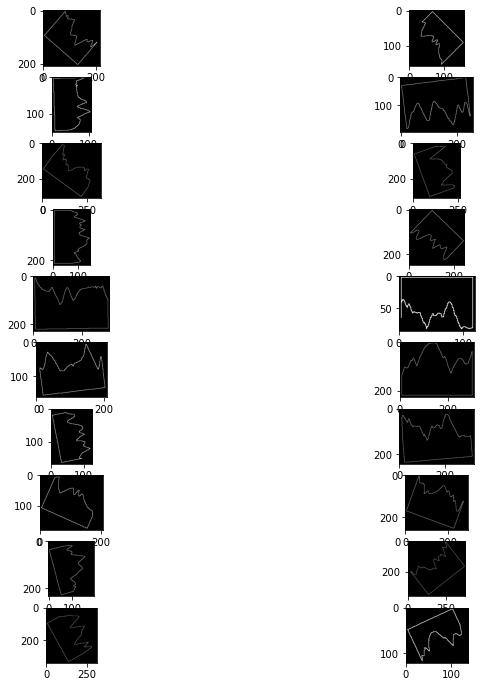

In [66]:
fig, axs = plt.subplots(int(len(images)/2),2, figsize=(12,12))
index = 0
for image in contursMaps:
    axs[math.floor(index / 2),index % 2].imshow(image, cmap='gray', vmin=0, vmax=1) 
    index += 1

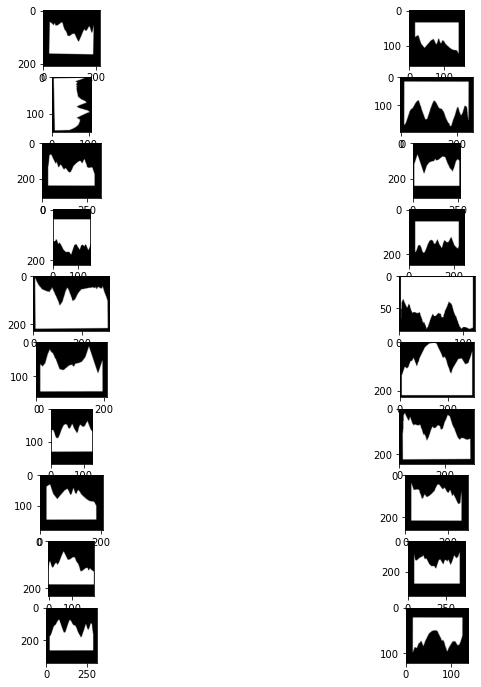

In [69]:
fig, axs = plt.subplots(int(len(images)/2),2, figsize=(12,12))
import imutils
index = 0

imgs_rotated = []

for image, contursMap in zip(numpyImages, contursMaps):
    
    angles = []
    
    lines = cv2.HoughLinesP(contursMap, 1, math.pi / 180.0, 50, minLineLength=50, maxLineGap=5)
    for x1, y1, x2, y2 in lines[0]:
        cv2.line(contursMap, (x1, y1), (x2, y2), (255, 0, 0), 3)
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)
        
    median_angle = np.median(angles)
    imgs_rotated.append(imutils.rotate(image, median_angle))
    
    axs[math.floor(index / 2),index % 2].imshow(imgs_rotated[-1], cmap='gray', vmin=0, vmax=255) 
    index += 1

In [101]:
def check_orient(image):
    height, width = image.shape
    # width, height = image.shape
    divider = 2
    black_pxls = []
    black_pxls.append(np.sum(image[:height // divider, :] == 0))  # up
    black_pxls.append(np.sum(image[(divider - 1) * (height // divider):, :] == 0))  # down    
    black_pxls.append(np.sum(image[:, :width // divider] == 0))  # left
    black_pxls.append(np.sum(image[:, (divider - 1) * (width // divider):] == 0))  # right
    
    side = black_pxls.index(max(black_pxls))
    if side == 0:
        return cv2.rotate(image, cv2.ROTATE_180)
    if side == 2:
        return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    if side == 3:
        return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    
    return image

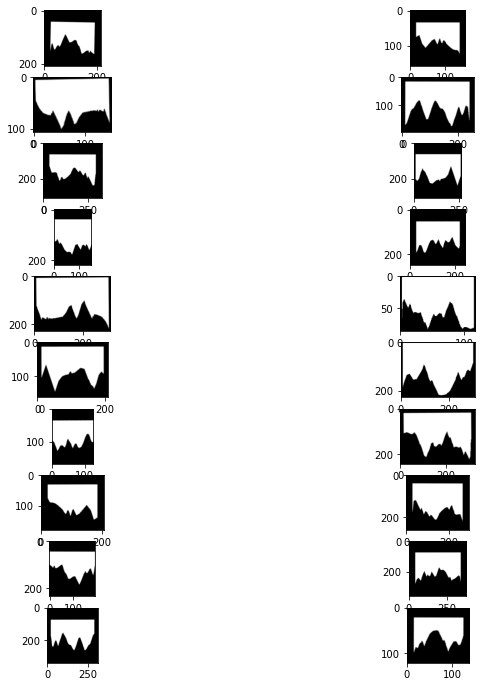

In [103]:
fig, axs = plt.subplots(int(len(images)/2),2, figsize=(12,12))
index = 0

imgs_fliped = []

for image in imgs_rotated:
    
    imgs_fliped.append(check_orient(image))   
    axs[math.floor(index / 2),index % 2].imshow(imgs_fliped[-1], cmap='gray', vmin=0, vmax=255) 
    
    index += 1 

In [104]:
def cut_background(image):
    
    upIndex = 0
    leftIndex = 0
    rightIndex = 0
    downIndex = 0
    
    for ind, row in enumerate(image):
        if any(row) > 0:
            upIndex = ind
            break
            
    for ind, column in enumerate(image.T):
        if any(column) > 0:
            leftIndex = ind
            break  
            
    for ind, row in enumerate(np.flip(image)):
        if any(row) > 0:
            downIndex = ind
            break
            
    for ind, column in enumerate(np.flip(image.T)):
        if any(column) > 0:
            rightIndex = ind
            break     
            
    newImage = image[upIndex:image.shape[0] - downIndex]
    
    newImage = np.delete(newImage, np.s_[newImage.shape[1] - rightIndex:newImage.shape[1]], 1) #column
    newImage = np.delete(newImage, np.s_[0:leftIndex], 1)

    
    return newImage

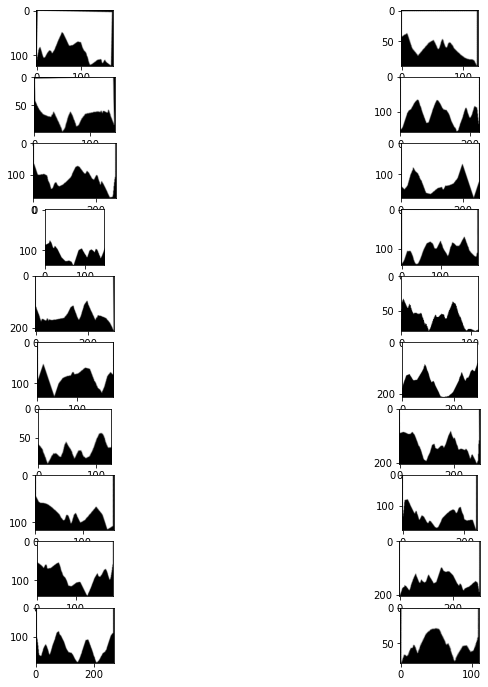

In [105]:
fig, axs = plt.subplots(int(len(images)/2),2, figsize=(12,12))
index = 0
cutted_images = []
for image in imgs_fliped:
        
    cutted_images.append(cut_background(image))
    axs[math.floor(index / 2),index % 2].imshow(cutted_images[-1], cmap='gray', vmin=0, vmax=255) 
    index += 1 

In [106]:
def cut_white_block(image):

    downIndex = 0
          
    height, width = image.shape
        
    accuracy = 0.02

    for ind, row in enumerate(np.flip(image)):
        
        left = int(width*accuracy)
        right = int(width-(width*accuracy))
        
        if all(row[left:right]) > 0:
            downIndex = ind
            break

    
    newImage = image[height - downIndex:]
    
    return newImage

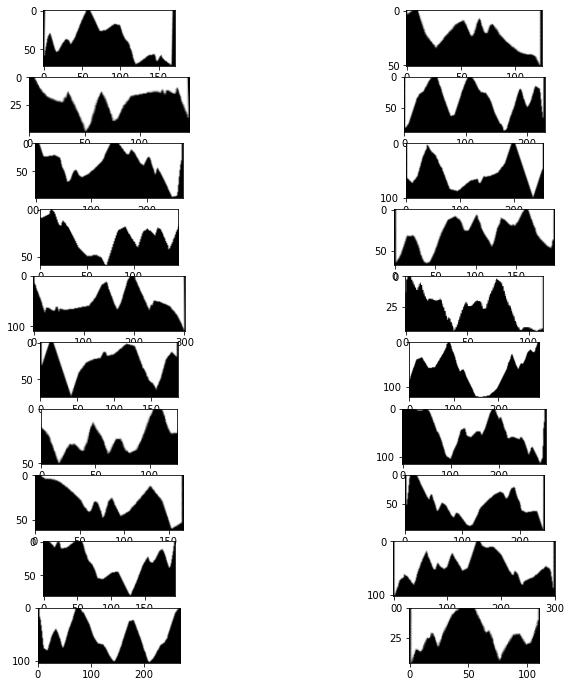

In [107]:
fig, axs = plt.subplots(int(len(images)/2),2, figsize=(12,12))
index = 0


ready_images = []

for image in cutted_images:
    
    ready_images.append(cut_white_block(image))
        
    axs[math.floor(index / 2),index % 2].imshow(ready_images[-1], cmap='gray', vmin=0, vmax=255) 
    index += 1

In [108]:
minHeight = None
minWidth = None

for image in ready_images:
    h,w = image.shape
    
    if minHeight == None or h < minHeight:
        minHeight = h
        
    if minWidth == None or w < minWidth:
        minWidth = w
    
print(minWidth, minHeight)
resized_images = []
for image in ready_images:
    resized_images.append(cv2.resize(image, dsize=(minWidth, minHeight), interpolation=cv2.INTER_CUBIC))

111 45


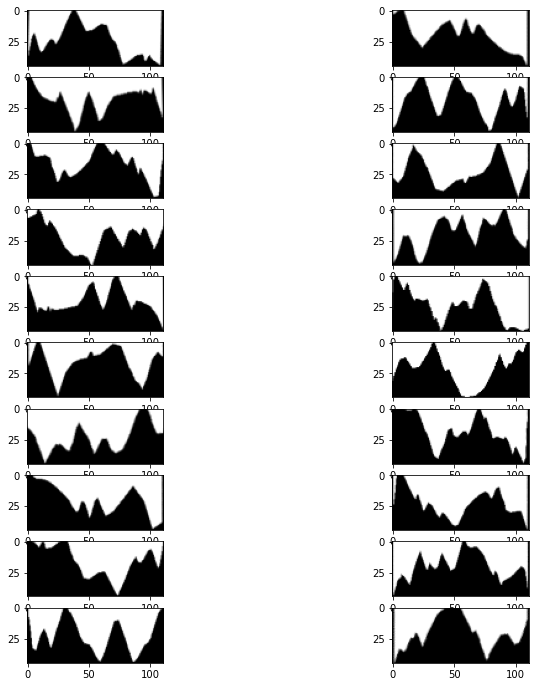

In [109]:
fig, axs = plt.subplots(int(len(images)/2),2, figsize=(12,12))
index = 0

for image in resized_images:
            
    axs[math.floor(index / 2),index % 2].imshow(image, cmap='gray', vmin=0, vmax=255) 
    index += 1 

In [110]:
def conutSimilarity(image1, image2):
    
    number_of_equal_elements = np.sum(image1==image2)
    total_elements = image1.shape[0] * image1.shape[1]
    percentage = number_of_equal_elements/total_elements
    
    return percentage

In [111]:
for index, image in enumerate(resized_images):
    best = None
    for index2, image2 in enumerate(resized_images):
        if index == index2:
            continue
        sim = conutSimilarity(np.flip(255 - image),image2)

        if best == None or sim > best:
            best = sim
            bestIndex = index2
            
            
    print(index, "most similar to", bestIndex)

0 most similar to 16
1 most similar to 14
2 most similar to 8
3 most similar to 18
4 most similar to 15
5 most similar to 10
6 most similar to 4
7 most similar to 12
8 most similar to 2
9 most similar to 13
10 most similar to 5
11 most similar to 19
12 most similar to 7
13 most similar to 9
14 most similar to 1
15 most similar to 4
16 most similar to 0
17 most similar to 6
18 most similar to 3
19 most similar to 11
